## seq2seq with attention
## translator

In this project we will be teaching a neural network to translate from English to Spanish.



sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. 
- An encoder network condenses an input sequence into a vector, 
- and a decoder network unfolds that vector into a new sequence.
- we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

I use pytorch's tutorial here as a guidance, which builds a french to english translator- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Pytorch tutorial simplifies a lot of aspects, such as stripping all accent marks, including small training dataset and etc. 

For the Spanish translator, I built a more complex data pipeline that includes the accents in the words and larger range of sentences. The model used is also more complex. Lastly I do some hyperparameter tuning on the learning rate. 



## google colab components

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 14 21:31:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/translate-to-spanish

/content/drive/MyDrive/Colab Notebooks/translate-to-spanish


In [ ]:
%ls

data/            loss_vs_iteration_model2.png  saved_models/
data-processed/  loss_vs_iteration_model3.png  translate-to-spanish.ipynb


In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/translate-to-spanish/'

## data

data/eng-fra.txt 
- tab separated list of translation pairs

someone did the extra work of splitting language pairs into individual text files here: 
https://www.manythings.org/anki/


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pickle

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## data pre-processing



In [ ]:
PAIRS = []
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    
    def processSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        

In [ ]:
'''
replace contractions in english
source: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
'''
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

test = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it."
print(decontracted(test))
# Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it.

Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it.


In [ ]:
# Lowercase, replace contractions, add space before and after punctuation
def normalizeEnglish(s):
    s = s.lower() 
    s = decontracted(s)
    s = re.sub(r"([.!?])", r" \1", s) #find puncts .!? and add space beforehand
    return s

# Lowercase, add space before and after punctuation
def normalizeSpanish(s):
    s = s.lower() 
    s = decontracted(s)
    s = re.sub(r"([.!?])", r" \1", s) #find puncts .!? and add space beforehand
    s = s.replace('¡', '¡ ') #add space after punctuation
    s = s.replace('¿', '¿ ')
    return s

In [ ]:
def readData(in_lang, out_lang):
    input_lang = Language(in_lang)
    output_lang = Language(out_lang)
    
    lines = open('data/spa.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize each
    PAIRS = []
    linecount = 0
    for l in lines:
      linecount+=1
      pairs = l.split('\t')[:2] #first & second are pairs, third tab not relevant
      PAIRS.append([normalizeEnglish(pairs[0]),normalizeSpanish(pairs[1])])

    #go through each pair & build Language Dictionary
    for pair in PAIRS:
      input_lang.processSentence(pair[0])
      output_lang.processSentence(pair[1])
        
    return input_lang, output_lang, PAIRS
              

In [ ]:
input_lang, output_lang, PAIRS = readData('eng', 'spa')

In [ ]:
n_examples = len(PAIRS)
print('Number of sentences read: ', n_examples)

Number of sentences read:  138437


In [ ]:
print('number of input words in vocab (english) ', input_lang.n_words)
print('number of output words in vocab (spanish) ', output_lang.n_words)
print('example ', random.choice(PAIRS))

number of input words in vocab (english)  16332
number of output words in vocab (spanish)  30630
example  ['why do not you get a haircut ?', '¿ por qué no te cortas el pelo ?']


In [ ]:
print(input_lang.word2index['word'])
print(output_lang.word2index['palabra'])

1758
2873


### store language class as pickle objects

In [ ]:
pickle_eng_out = open("data-processed/eng.pickle", "wb")
pickle.dump(input_lang, pickle_eng_out )
pickle_eng_out.close()

pickle_spa_out = open("data-processed/spa.pickle", "wb")
pickle.dump(output_lang, pickle_spa_out )
pickle_spa_out.close()

In [ ]:
import pickle

txt = "hi"
pickle_out = open("test.pickle", "wb")
pickle.dump(txt, pickle_out)
pickle_out.close()


In [ ]:
pickle_in = open("test.pickle", "rb")
text_in = pickle.load(pickle_in)
print(text_in)

hi


### load language class as pickle objects

In [ ]:
pickle_eng_in = open("data-processed/eng.pickle", "rb")
pickle_spa_in = open("data-processed/spa.pickle", "rb")
input_lang = pickle.load(pickle_eng_in)
output_lang = pickle.load(pickle_spa_in)

In [ ]:
print(input_lang.word2index['word'])
print(output_lang.word2index['palabra'])

1758
2873


### filter pairs to reduce sentences to embed

In [ ]:
print('example ', random.choice(PAIRS))

example  ['some people gain weight when they quit smoking .', 'algunas personas engordan cuando dejan de fumar .']


In [ ]:
ex = random.sample(PAIRS,10)
print(ex)

[['you should have attended today is meeting .', 'tenías que haber asistido a la reunión de hoy .'], ['he is not a smoker .', 'él no es fumador .'], ['let is keep this a secret .', 'mantengamos esto en secreto .'], ['who is that man ?', '¿ quién es ese hombre ?'], ['ask the waitress for the menu .', 'pídale el menú a la camarera .'], ['her hair did not look dyed .', 'su pelo no se veía teñido .'], ['it is quiet .', 'es silencioso .'], ['why worry about it ?', '¿ por qué preocuparse ?'], ['what time do you want me to pick you up ?', '¿ a qué hora quieres que te pase a buscar ?'], ['mary is sewing baby clothes .', 'mary está cosiendo ropa de bebé .']]


In [ ]:
#filter pairs by length & 
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", 
    "he is", 
    "she is", 
    "you are", 
    "we are", 
    "they are"
)
def filterCondition(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)
    
def filterPairs(pairs):
    return [pair for pair in pairs if filterCondition(pair)]


In [ ]:
pairs_filtered = filterPairs(PAIRS)
print(len(PAIRS), len(pairs_filtered))

138437 8483


In [ ]:
ex = random.sample(pairs_filtered,10)
print(ex)

[['i am not a kid .', '¡ no soy un niño !'], ['they are both in the room .', 'los dos están en la pieza .'], ['we are expecting a good harvest this year .', 'este año esperamos una buena cosecha .'], ['she is in the hospital now .', 'ella ahora está en el hospital .'], ['i am always in a bad mood .', 'estoy siempre malhumorado .'], ['we are with you .', 'estamos con vos .'], ['he is just a kid .', 'solo es un niño .'], ['she is a wonderful woman .', 'ella es una mujer maravillosa .'], ['you are so predictable .', 'eres tan predecible .'], ['they are interns .', 'están en prácticas .']]


### convert words to tensor

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [ ]:
sample = random.choice(pairs_filtered)
print(sample)
sent1 = sample[0]
ind1 = []
for word in sent1.split(' '):
    print(word, input_lang.word2index[word])
    ind1.append(input_lang.word2index[word])
for word in sample[1].split(' '):
    print(word, output_lang.word2index[word])
    
print(ind1)
ind1.append(EOS_token)
print(ind1)

['i am a bank employee .', 'soy empleado de un banco .']
i 20
am 54
a 132
bank 2295
employee 4054
. 3
soy 224
empleado 8129
de 109
un 181
banco 4794
. 3
[20, 54, 132, 2295, 4054, 3]
[20, 54, 132, 2295, 4054, 3, 1]


In [ ]:
print(torch.tensor(ind1, dtype=torch.long, device=device).view(-1,1).size())
print(torch.tensor(ind1, dtype=torch.long, device=device).unsqueeze(1).size())

torch.Size([7, 1])
torch.Size([7, 1])


## utils: measuring training time functions

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Model

### create model

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        #convert input to embedding
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        #pass embedding to gru
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### train sequence

#### **train function**


#### **train iteration**
What it does
1. starts timer
2. initializes encoder & decoder optimizer
3. initilatizes Loss function (criterion)
4. generates training_pairs = number of iterations
  - gets a random sample from pairs_filtered
  - calls tensorsFromPair to convert to tensor

5. For each iteration:
  - selects one from training_pairs at that iteration #
  - input_tensor and output_tensor
  - sends to train() function and gets back loss number
    - input_tensor, target_tensor, 
    - encoder, decoder, 
    - encoder_optimizer, decoder_optimizer, 
    - criterion
  - prints loss & time

### train
Steps
1. Receives input & target tensor, encoder, decoder, optimizers, loss function
2. initializes encoder_hidder
3. sets encoder_optimizer & decoder_optimizer to zero_grad()
4. encoder_outputs initialized to zero
5. loss initialized to zero
6. encoder, for each word in input:
    - pass to encoder
    - get back encoder_output & encoder_hidden
 

7. decoder
  - for it on target_length
  - Performs an inference - that is, gets predictions
  - Calculates the loss on decoder output vs target output for each word
  - sums loss


8. Loss propagated backwards- calculates backward gradients over the learning weights
9. Encoder_optimizer & decoder_optimizer takes step
  - aka tells the optimizer to perform one learning step  
  - this adjusts the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
10. send loss back as sum of loss at each step/target_length

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print("inpute length ", input_length, "target length", target_length)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #print('decoder_attention size ', decoder_attention.size())
            #print('decoder_output size ', decoder_output.size())
            #print('decoder_hidden size ', decoder_hidden.size())
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [ ]:

training_pair = tensorsFromPair(random.choice(pairs_filtered))
print(training_pair)
input_tensor = training_pair[0]
target_tensor = training_pair[1]
print('input tensor size ', input_tensor.size()) #9 by 1
print('target tensor size ', target_tensor.size()) #7 by 1
hidden_size = 256
learning_rate = 0.01

encoder = EncoderRNN(input_lang.n_words, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
encoder.to(device)
decoder.to(device)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()  


loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)


(tensor([[ 37],
        [104],
        [500],
        [347],
        [261],
        [  3],
        [  1]], device='cuda:0'), tensor([[  77],
        [1151],
        [2081],
        [ 109],
        [ 327],
        [ 560],
        [   3],
        [   1]], device='cuda:0'))
input tensor size  torch.Size([7, 1])
target tensor size  torch.Size([8, 1])


### train iterations


In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    plot_losses_x = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    training_pairs = [tensorsFromPair(random.choice(pairs_filtered))
                      for i in range(n_iters)]
   

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_losses_x.append(iter)
            plot_loss_total = 0

    end = time.time()
    total_time = end - start

    return plot_losses, plot_losses_x, total_time

In [ ]:
time_vs_iteration = []
loss_vs_iteration = []

In [ ]:
hidden_size = 256
n_iters = 85000

encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses, plot_losses_x, total_time = trainIters(encoder3, attn_decoder3, n_iters, print_every=5000)

1m 29s (- 23m 53s) (5000 5%) 3.6370
2m 53s (- 21m 44s) (10000 11%) 2.6472
4m 17s (- 20m 3s) (15000 17%) 2.2210
5m 41s (- 18m 30s) (20000 23%) 1.9516
7m 5s (- 17m 1s) (25000 29%) 1.7620
8m 30s (- 15m 35s) (30000 35%) 1.6791
9m 54s (- 14m 8s) (35000 41%) 1.5956
11m 17s (- 12m 42s) (40000 47%) 1.5146
12m 41s (- 11m 17s) (45000 52%) 1.4619
14m 6s (- 9m 52s) (50000 58%) 1.4372
15m 30s (- 8m 27s) (55000 64%) 1.3665
16m 54s (- 7m 2s) (60000 70%) 1.3745
18m 18s (- 5m 38s) (65000 76%) 1.3130
19m 42s (- 4m 13s) (70000 82%) 1.3214
21m 7s (- 2m 49s) (75000 88%) 1.2620
22m 31s (- 1m 24s) (80000 94%) 1.2326
23m 56s (- 0m 0s) (85000 100%) 1.1887


In [ ]:
time_vs_iteration.append(['m3', n_iters, total_time])
loss_vs_iteration.append(['m3', n_iters, plot_losses[-1]])

In [ ]:
print(time_vs_iteration)
print(loss_vs_iteration)

[['m1', 5000, 70.11749505996704], ['m1', 50000, 699.68], ['m2', 50000, 839.716450214386], ['m3', 85000, 1436.4116787910461]]
[['m1', 5000, 3.727539761823321], ['m1', 50000, 1.3542006827136353], ['m2', 50000, 1.3695086798078964], ['m3', 85000, 1.2922771894781595]]


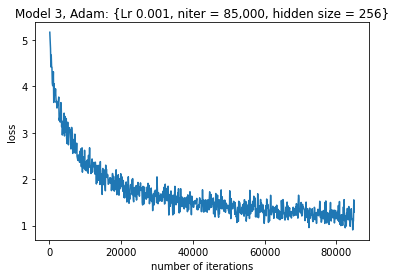

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
plt.plot(plot_losses_x, plot_losses)
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.title('Model 3, Adam: {Lr 0.001, niter = 85,000, hidden size = 256}')
plt.show()
plt.savefig('loss_vs_iteration_model3.png')

## evaluation

In [ ]:
def evaluate(sentence, input_lang,  encoder, decoder,max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden
        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()  # detach from history as input
    return decoded_words

In [ ]:
sentence = 'i am happy .'

In [ ]:
sentence = random.choice(pairs_filtered)[0]
print(sentence)

she is forgotten how to do it .


In [ ]:
print(evaluate(sentence,input_lang,encoder2, attn_decoder2))

['ha', 'olvidado', 'hacerlo', 'modo', '.', '<EOS>']


In [ ]:
def evaluateRandomly(input_lang, encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_filtered)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(pair[0], input_lang, encoder, decoder)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(input_lang,encoder3, attn_decoder3)

> i am an adult .
= soy adulto .
< soy adulta . <EOS>

> she is busy cooking dinner .
= ella está ocupada preparando la cena .
< ella está ocupada preparando . <EOS>

> they are interesting people .
= ellos son gente interesante .
< son son . <EOS>

> we are ambidextrous .
= somos ambidextros .
< estamos seguros . <EOS>

> i am a bit drunk .
= estoy un poquito borracho .
< estoy un poco borracho . <EOS>

> i am tom .
= soy tom .
< soy tom . <EOS>

> i am in jail .
= estoy en la cárcel .
< estoy en la cárcel . <EOS>

> she is not much of a poet .
= no es una buena poetisa .
< no es un buen lo que . <EOS>

> he is no longer here .
= él ya no está aquí .
< él ya no está . <EOS>

> you are all crazy .
= todos estáis locos .
< todos estáis locos . <EOS>



### save model weights

**Model 1:**
- encoder_lr0.01_hs256_niter50000_engprefix
- attn decoder
- SGD, lr 0.01
  - n_iters = 50,000
  - eng prefix only, 8483 sentences
  - epochs ~5.89
  - hidden size = 256
  - max length 10
  - dropout 0.1
  - teacher forcing 0.5
- time: 699.68seconds, 11 minutes
- loss at end: 1.4106

**Model 2:**
- encoder_lr0.001_hs256_niter50000_engprefix
- attn decoder
- Adam, lr 0.001
  - n_iters = 50,000
  - eng prefix only, 8483 sentences
  - epochs ~5.89
  - hidden size = 256
  - max length 10
  - dropout 0.1
  - teacher forcing 0.5
- time: 839.71 (14 min)
- loss at end: 1.42

**Model 3:**
- encoder_lr0.001_hs256_niter85000_engprefix
- attn decoder
- Adam, lr 0.001
  - n_iters = 85,000
  - eng prefix only, 8483 sentences
  - epochs ~10
  - hidden size = 256
  - max length 10
  - dropout 0.1
  - teacher forcing 0.5
- time: 1436.411 (24 min)
- loss at end: 1.29

In [ ]:
torch.save(encoder3.state_dict(), 'saved_models/encoder_3.h5')

##### encoder 2 rewritten by encoder 3 :(

In [ ]:
torch.save(attn_decoder3.state_dict(), 'saved_models/decoder_3.h5')

In [ ]:
hidden_size = 256
encoder_1_load = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_1_load = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

encoder_1_load.load_state_dict(torch.load('saved_models/encoder_3.h5'))
attn_decoder_1_load.load_state_dict(torch.load('saved_models/decoder_3.h5'))


<All keys matched successfully>

In [ ]:
sentence = random.choice(pairs_filtered)[0]
print(sentence)

she is good at imitating him .


In [ ]:
print(evaluate(sentence,input_lang,encoder_1_load, attn_decoder_1_load))

['soy', 'feliz', '.', '<EOS>']


In [ ]:
l = ['soy', 'feliz', '.', '<EOS>']

In [ ]:
s= ' '.join(l[:-1])
print(s)

soy feliz .


In [ ]:
import re
s= re.sub(r'\s([?.!"](?:\s|$))', r'\1', s)

print(s)

soy feliz.
